In [42]:
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from wordcloud import WordCloud
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from tqdm import tqdm
import scipy.sparse
import pickle

import warnings
warnings.filterwarnings("ignore")

# Loading Raw Train Dataset:

In [3]:
data = pd.read_csv("data/Train.csv", usecols=["Id"])
print("Number of rows in dataset:",data.shape)

Number of rows in dataset: (6034195, 1)


In [4]:
data = pd.read_csv("data/Train.csv", nrows=5)
print("Columns in Train Data:",data.columns)
data.head()

Columns in Train Data: Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


# Exploratory Data Analysis:

## Preprocessing of Data:

In [ ]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
with open('Train.csv', mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line=0
    count=1
    for row in tqdm(csv_reader):
        Id, Title, Body, Tags = row["Id"], row["Title"], row["Body"], row["Tags"]
        line+=1
        is_code=0
        code_str=""
        
        if '<code>' in Body:
            is_code = 1
            code = re.findall('<code>(.*?)</code>', Body, flags=re.MULTILINE|re.DOTALL)
            code_str = code_str.join(code)
        
        question=re.sub('<code>(.*?)</code>', '', Body, flags=re.MULTILINE|re.DOTALL)
        
        question=striphtml(question.encode('utf-8'))
        question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
        words=word_tokenize(str(question.lower()))
        question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
        
        Title=striphtml(Title.encode('utf-8'))
        Title=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',Title)
        words=word_tokenize(str(Title.lower()))
        Title=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
        
        
        sent=""
        dup = dict()
        for ch in code_str:
            ch=ch.lower()
            if(ch.isalpha()):
                sent+=(ch)
            if(ch in [' ','.','(',')','{','}','[',']','_','-','/','$','&','<','>',':',';','/','\\',"'",'?','!','@','#','%','^','*','+','=','|']):
                if(ch not in dup):
                    dup[ch]=(int)(1)
                if(dup.get(ch)<=5):
                    dup[ch]=(int)(dup.get(ch)+1)
                    sent+=" "+ch+" "
                else:
                    sent+=" "

        dup = dict()
        sent1=""
        for ch in sent.split():
            if(ch not in dup):
                dup[ch]=(int)(1)
            if(dup.get(ch)<=10):
                dup[ch]=(int)(dup.get(ch)+1)
                sent1+=" "+ch+" "
            else:
                sent1+=" "


        sent1=' '.join(sent1.split())
        
        row_series = pd.Series((Id,Title,question,sent1,is_code,Tags),index=["Id","Title","Question","code","is_code","Tags"])
        preprocessed_data = preprocessed_data.append(row_series, ignore_index = True)
        
        if(line%10000==0):
            preprocessed_data.to_csv("preprocessed/preprocessed_data"+str(count)+".csv")
            preprocessed_data = pd.DataFrame(columns=["Id","Title","Question","code","is_code","Tags"])

preprocessed_data.to_csv("preprocessed/preprocessed_data"+str(count+1)+".csv")
csv_file.close()

In [ ]:
preprocessed_data.to_csv("preprocessed/preprocessed_data604.csv")

### Combining all preprocessed data:

In [ ]:
preprocessed_data_all = pd.read_csv("preprocessed/preprocessed_data1.csv")

In [ ]:
for i in tqdm(range(2,605)):
    preprocessed_data_all = pd.concat([preprocessed_data_all,pd.read_csv("preprocessed/preprocessed_data"+str(i)+".csv")])

In [6]:
preprocessed_data_all.shape

(6034195, 7)

In [ ]:
preprocessed_data_all.to_csv("data/final_preprocessed_data.csv",index=False)

In [7]:
preprocessed_data_all.head()

,Unnamed: 0,Id,Title,Question,code,is_code,Tags
0,0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


## Loading of Pre-Processed Data:

In [5]:
preprocessed_data = pd.read_csv("data/final_preprocessed_data.csv")

## Handling Duplicates:

In [2]:
#preprocessed_data_all = pd.read_csv("data/final_preprocessed_data_no_dup.csv")

In [ ]:
preprocessed_data_all = preprocessed_data[~preprocessed_data.duplicated(["Title","Tags"], keep='first')]

In [5]:
print("Number of duplicate rows :",preprocessed_data.shape[0]-preprocessed_data_all.shape[0])
print("Percent of duplicate rows :",((preprocessed_data.shape[0]-preprocessed_data_all.shape[0])/(preprocessed_data.shape[0]))*100,"%")

Number of duplicate rows : 1848011
Percent of duplicate rows : 44.14547951069518 %


In [6]:
print("Number of rows and columns:",preprocessed_data_all.shape)

Number of rows and columns: (4178926, 6)


In [7]:
preprocessed_data_all.head()

,Id,Title,Question,code,is_code,Tags
0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


## Finding Tags with null values:

In [8]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Tags"].isna()))

Number of rows with null tags: 7


In [9]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Tags"].isna()]

In [10]:
preprocessed_data_all.shape

(4178919, 6)

## Finding Title with null values:

In [11]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Title"].isna()))

Number of rows with null tags: 142


In [12]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Title"].isna()]

In [13]:
preprocessed_data_all.shape

(4178777, 6)

## Finding Question with null values:

In [14]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Question"].isna()))

Number of rows with null tags: 2701


In [15]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Question"].isna()]

In [16]:
preprocessed_data_all.shape

(4176076, 6)

## EDA on Tags:

In [17]:
tag_count = preprocessed_data_all['Tags'].map(lambda x : (len(x.split())))

In [18]:
pd.value_counts(tag_count)

3    1199093
2    1102709
4     810488
1     561590
5     502196
Name: Tags, dtype: int64

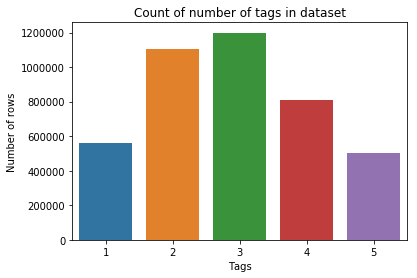

In [19]:
sns.countplot(tag_count)
plt.title("Count of number of tags in dataset")
plt.ylabel("Number of rows")
plt.show()

### Finding frequency of each tag

In [20]:
tag_dict={}

for line in tqdm(preprocessed_data_all["Tags"]):
    for tag in line.split():
        if tag not in tag_dict:
            tag_dict[tag]=1
        else:
            tag_dict[tag]=tag_dict[tag]+1

100%|████████████████████████████████████████████████████████████████████| 4176076/4176076 [00:07<00:00, 567841.47it/s]


#### 20 most occuring tags

In [21]:
from operator import itemgetter
tag_dict_sort = sorted(tag_dict.items(), key = itemgetter(1), reverse = True)
tag_dict_sort[:20]

[('c#', 329491),
 ('java', 297149),
 ('php', 282019),
 ('javascript', 263404),
 ('android', 233301),
 ('jquery', 220039),
 ('c++', 142857),
 ('python', 133064),
 ('iphone', 127797),
 ('asp.net', 124961),
 ('mysql', 121797),
 ('html', 119545),
 ('.net', 113348),
 ('ios', 100476),
 ('objective-c', 95438),
 ('sql', 94606),
 ('css', 93134),
 ('ruby-on-rails', 83054),
 ('linux', 78076),
 ('c', 68616)]

#### 50 most occuring tags in plot

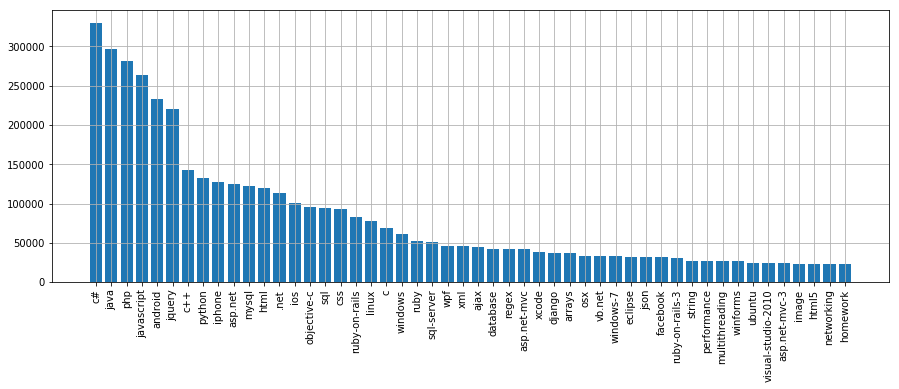

In [22]:
num_tags=[]
name_tags=[]

for x in tag_dict_sort:
    num_tags.append(x[1])
    name_tags.append(x[0])

plt.figure(figsize=(15,5))
plt.bar(range(50), num_tags[:50])
plt.xticks(range(50), name_tags[:50], rotation=90)
plt.grid()
plt.show()

#### we can observe that tags such as : C# , java , php , javascript , android , jquery are most occuring words.

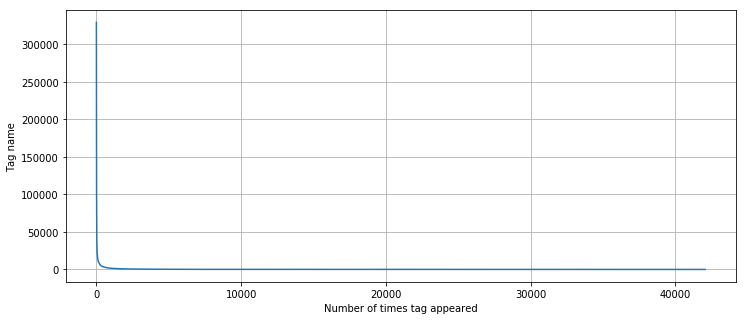

In [23]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(num_tags),1),num_tags)

plt.grid()
plt.ylabel("Tag name")
plt.xlabel("Number of times tag appeared")
plt.show()

## EDA on Title:

In [24]:
title_length=preprocessed_data_all['Title'].map(lambda x : (len(x.split())))

Text(0.5,1,'Title length distribution')

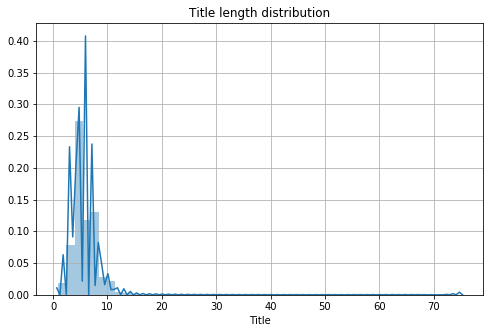

In [25]:
plt.figure(figsize=(8,5))
sns.distplot(title_length)
plt.grid()
plt.title('Title length distribution')

### save final dataset:

In [26]:
preprocessed_data_all.to_csv("final_training_preprocessed.csv",index=False)

## Pre-processing Encoding of tags:

In [37]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data_all['Tags'])

In [38]:
len(vectorizer.get_feature_names())

42048

In [39]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [8]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data_all.shape[0]
for i in tqdm(range(100, total_tags, 100)):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

100%|████████████████████████████████████████████████████████████████████████████████| 416/416 [04:32<00:00,  1.51it/s]


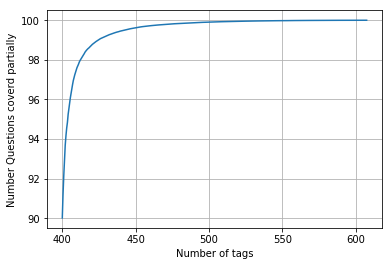

In [40]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(400+np.array(range(-50,450,50)))
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [41]:
# we will be taking 100 tags
num_of_tags=100
multilabel_yx = tags_to_choose(num_of_tags)
print("number of questions that are not covered :", questions_explained_fn(num_of_tags),"out of ", total_qs)
print("% of questions that are not covered :", (questions_explained_fn(num_of_tags)/total_qs)*100.0)

number of questions that are not covered : 981172 out of  4176076
% of questions that are not covered : 23.49507049201212


In [42]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 42048
number of tags taken : 100 ( 0.2378234398782344 %)


## Masking DataFrame:

In [43]:
tags=[x[0] for x in tag_dict_sort[:100]]

In [44]:
count=[]
for i,x in (enumerate(preprocessed_data_all["Tags"])):
    for tag in x.split():
        if(tag in tags):
            count.append(i)
            break

In [45]:
len(count)

3194904

In [46]:
count = count[:1000000]

In [47]:
preprocessed_data_all = preprocessed_data_all.iloc[count]

In [48]:
preprocessed_data_all.shape

(1000000, 6)

In [49]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data_all['Tags'])

In [50]:
len(vectorizer.get_feature_names())

31616

In [51]:
num_of_tags=100
multilabel_yx = tags_to_choose(num_of_tags)

In [52]:
multilabel_yx

<1000000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 1574248 stored elements in Compressed Sparse Row format>

### Saving final dataset:

In [74]:
preprocessed_data_all.to_csv("data/final_dataset_train_1L.csv",index=False)

In [76]:
scipy.sparse.save_npz('data/class_label_1L_sparse_matrix.npz', multilabel_yx)

In [80]:
multilabel_yx = scipy.sparse.load_npz("data/class_label_1L_sparse_matrix.npz")

In [146]:
preprocessed_data_all = pd.read_csv("data/final_dataset_train_1L.csv")

## Train-Test Split:

In [147]:
train_size=700000

x_train = preprocessed_data_all[:train_size]
x_test = preprocessed_data_all[train_size:]

y_train = multilabel_yx[:train_size]
y_test = multilabel_yx[train_size:]

In [148]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (700000, 100)
Number of data points in test data : (300000, 100)


In [149]:
print("Number of data points in train data :", x_train.shape)
print("Number of data points in test data :", x_test.shape)

Number of data points in train data : (700000, 6)
Number of data points in test data : (300000, 6)


In [84]:
x_train.head()

,Id,Title,Question,code,is_code,Tags
0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


# Featurizing data with BoW vectorizer 

In [87]:
train_text = x_train['Title']+" "+x_train['Question']
test_text = x_test['Title']+" "+x_test['Question']

In [88]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [89]:
len(vectorizer.get_feature_names())

10583

## Logistic Regression:

In [92]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:05.742026


In [93]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.29468333333333335
Hamming loss  0.011647733333333334


In [94]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6812, Recall: 0.4900, F1-measure: 0.5700


In [96]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  16.93478872920469


In [97]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

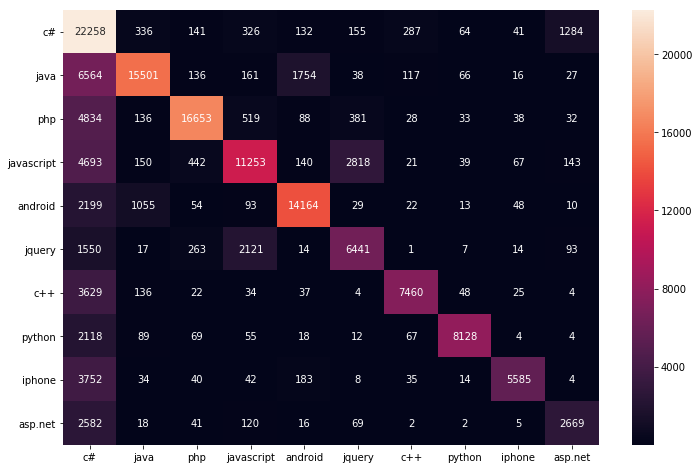

In [98]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model

In [99]:
with open('models/LR_title_question.pkl', 'wb') as f:
    pickle.dump(classifier, f)

## Random Forest

In [100]:
start = datetime.now()
classifier = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:19.621517


In [101]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.1936
Hamming loss  0.012723233333333334


In [102]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.8236, Recall: 0.2448, F1-measure: 0.3775


In [103]:
#macro f1 score
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Macro-average quality numbers
Precision: 0.7233, Recall: 0.1424, F1-measure: 0.2089


In [104]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  14.365051612818375


In [105]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

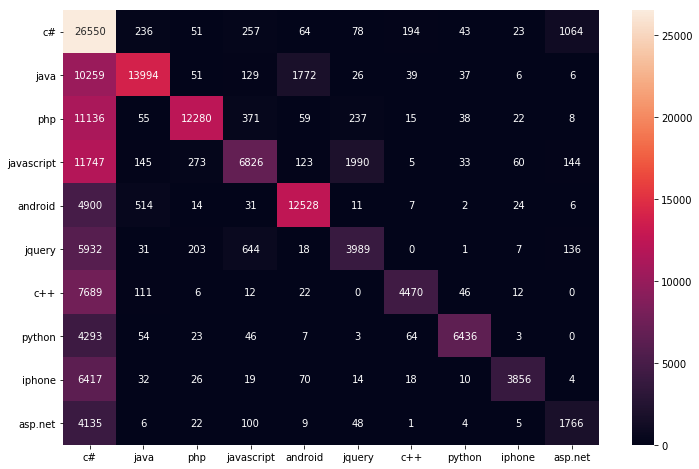

In [106]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model:

In [107]:
with open('models/RF_title_question.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [108]:
with(open("models/vectorizer_title_question.pkl", "wb")) as file:
    pickle.dump(vectorizer.get_feature_names(), file)

## Model using (3 times repetition of title) + question:

In [109]:
train_text = x_train['Title']+" "+x_train['Title']+" "+x_train['Title']+" "+x_train['Question']
test_text = x_test['Title']+" "+x_test['Title']+" "+x_test['Title']+" "+x_test['Question']

In [110]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [111]:
len(vectorizer.get_feature_names())

10583

In [108]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (700000, 10349) Y : (700000, 100)
Dimensions of test data X: (300000, 10349) Y: (300000, 100)


# Logistic Regression:

In [112]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:12.122475


In [113]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.30156666666666665
Hamming loss  0.011642033333333333


In [114]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6739, Recall: 0.5058, F1-measure: 0.5778


In [115]:
#macro f1 score
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Macro-average quality numbers
Precision: 0.5990, Recall: 0.4672, F1-measure: 0.5231


In [116]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  17.32676821030963


In [117]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

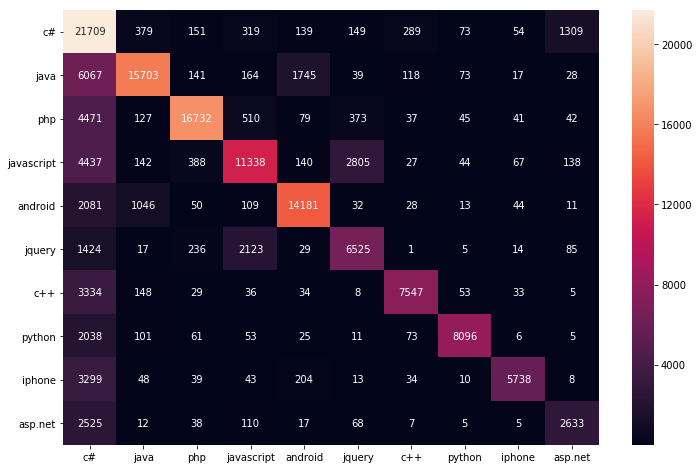

In [118]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

## Random Forest:

In [119]:
start = datetime.now()
classifier = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:07.301862


In [120]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.21097
Hamming loss  0.0123473


In [121]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.8409, Recall: 0.2667, F1-measure: 0.4050


In [122]:
#macro f1 score
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Macro-average quality numbers
Precision: 0.7233, Recall: 0.1678, F1-measure: 0.2433


In [123]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  14.451681102320014


In [124]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

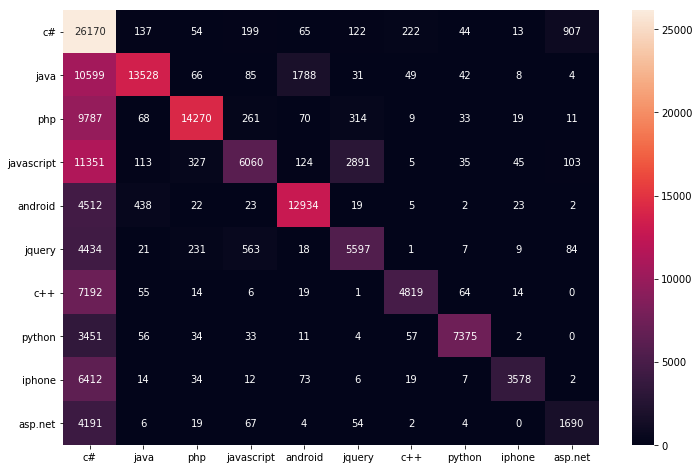

In [126]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

## Model using (3 times repetition of title) + question+code:

In [151]:
x_train["code"]=x_train["code"].fillna(" ")
x_test["code"]=x_test["code"].fillna(" ")

In [152]:
train_text = x_train['Title']+" "+x_train['Title']+" "+x_train['Title']+" "+x_train['Question']+" "+x_train["code"]
test_text = x_test['Title']+" "+x_test['Title']+" "+x_test['Title']+" "+x_test['Question']+" "+x_test["code"]

In [153]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [154]:
len(vectorizer.get_feature_names())

20669

# Logistic Regression:

In [127]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:07.325416


In [128]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.30157666666666666
Hamming loss  0.011642566666666666


In [129]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6739, Recall: 0.5057, F1-measure: 0.5778


In [130]:
#macro f1 score
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Macro-average quality numbers
Precision: 0.5990, Recall: 0.4672, F1-measure: 0.5231


In [131]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  17.324505264528252


In [132]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

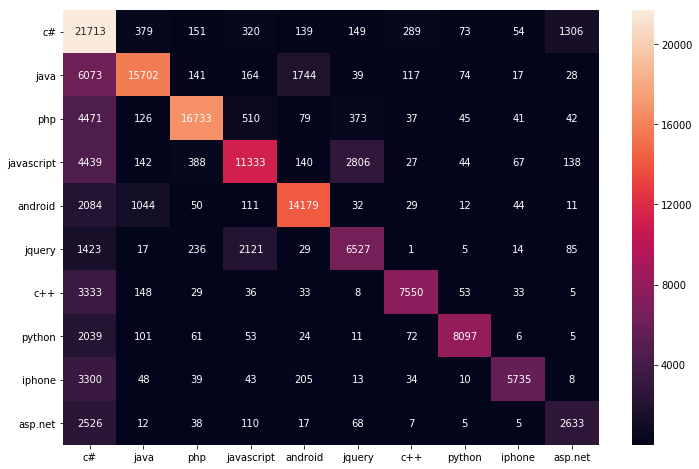

In [133]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model:

In [132]:
with open('models/LR_3title_question_code.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [133]:
with(open("models/vectorizer_3title_question_code.pkl", "wb")) as file:
    pickle.dump(vectorizer.get_feature_names(), file)

In [240]:
tags=[x[0] for x in tag_dict_sort[:100]]

In [241]:
with open('models/tags_list.txt', 'w') as f:
    for item in tags:
        f.write("%s " % item)

## Getting best model by hyperparameter tuning:

In [140]:
x_train["code"]=x_train["code"].fillna(" ")
x_test["code"]=x_test["code"].fillna(" ")

In [141]:
train_text = x_train['Title']+" "+x_train['Title']+" "+x_train['Title']+" "+x_train['Question']
test_text = x_test['Title']+" "+x_test['Title']+" "+x_test['Title']+" "+x_test['Question']

In [142]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [143]:
len(vectorizer.get_feature_names())

29511

## Hyperparameter Tuning Logistic Regression:

In [27]:
for c in [10**-2,10**-1,1,5,10]:
    classifier = OneVsRestClassifier(LogisticRegression(C=c, penalty='l1'))
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    acc = metrics.accuracy_score(y_test, predictions)
    hl = metrics.hamming_loss(y_test,predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    ll = metrics.log_loss(y_test.todense(), predictions.todense())
    print("C:",c)
    print("Accuracy :",acc,"Hamming loss ",hl,"Log loss : ",ll)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print()

C: 0.01
Accuracy : 0.26562857142857144 Hamming loss  0.011139857142857142 Log loss :  14.551605421689315
Precision: 0.8073, Recall: 0.3815, F1-measure: 0.5182

C: 0.1
Accuracy : 0.3264142857142857 Hamming loss  0.010324 Log loss :  15.19721773111653
Precision: 0.7792, Recall: 0.4778, F1-measure: 0.5924

C: 1
Accuracy : 0.3107285714285714 Hamming loss  0.011589571428571428 Log loss :  17.2553864197234
Precision: 0.6590, Recall: 0.5427, F1-measure: 0.5952

C: 5
Accuracy : 0.2611428571428571 Hamming loss  0.01406542857142857 Log loss :  19.30762996335121
Precision: 0.5513, Recall: 0.5600, F1-measure: 0.5556

C: 10
Accuracy : 0.24152857142857143 Hamming loss  0.015036285714285714 Log loss :  19.998130353058855
Precision: 0.5196, Recall: 0.5604, F1-measure: 0.5393



### best model

In [155]:
classifier = OneVsRestClassifier(LogisticRegression(C=0.5, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [156]:
f1_score(y_test, predictions, average='micro')

0.6042864230997301

In [157]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

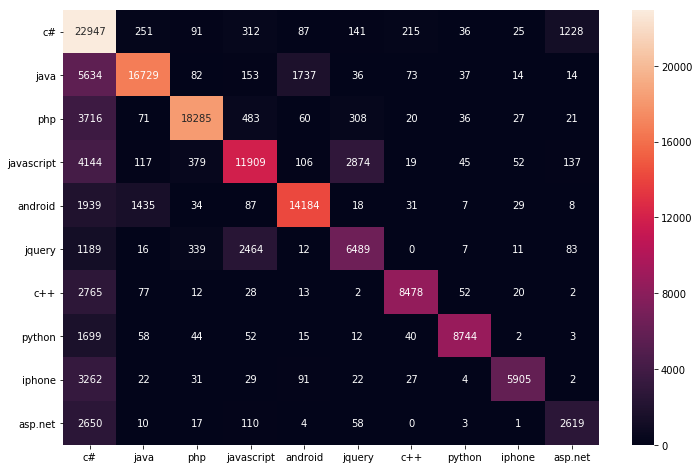

In [159]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model:

In [158]:
with open('model/LR_3title_question_code_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

#### Precision and Recall score of each top 100 tags:

In [160]:
from prettytable import PrettyTable

In [161]:
pt = PrettyTable(["TAG", "PRECISION", "RECALL"])

precision_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[i][j]
    precision_score.append(matrix[i][i]/score)
    
recall_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[j][i]
    recall_score.append(matrix[i][i]/score)
    
for tag,p_score,r_score in zip(tags,precision_score,recall_score):
    pt.add_row([tag, p_score, r_score])

In [162]:
print(pt)

+--------------------+----------------------+---------------------+
|        TAG         |      PRECISION       |        RECALL       |
+--------------------+----------------------+---------------------+
|         c#         |  0.7531261281958712  |  0.2627047819665938 |
|        java        |  0.6174429763047169  |  0.7990160959067679 |
|        php         |  0.7059300440120454  |  0.8367655134541461 |
|     javascript     |  0.5426006925460178  |  0.6961070844049567 |
|      android       |  0.7811863193258798  |  0.8509719222462203 |
|       jquery       |  0.5734865223155103  |  0.6098111079785734 |
|        c++         |  0.6702506126966559  |  0.8343666961913198 |
|       python       |  0.7422120363296834  |  0.8841253791708796 |
|       iphone       |  0.5098428596097393  |  0.6698808848553602 |
|      asp.net       | 0.40973091364205255  |  0.5316686967113277 |
|       mysql        |  0.6412648221343874  |  0.6946394930638808 |
|        html        | 0.31991005723630417  |  0

## Hyperparameter Tuning Gradient Boosting DT:

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

In [145]:
for c in [50,100,250,500]:
    classifier = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=c))
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    acc = metrics.accuracy_score(y_test, predictions)
    hl = metrics.hamming_loss(y_test,predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    ll = metrics.log_loss(y_test.todense(), predictions.todense())
    print("n_estimator : ",c)
    print("Accuracy :",acc,"Hamming loss ",hl,"Log loss : ",ll)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print()

n_estimator :  50
Accuracy : 0.27199 Hamming loss  0.011810566666666666 Log loss :  17.353249860438794
Precision: 0.6936, Recall: 0.4483, F1-measure: 0.5446

n_estimator :  100
Accuracy : 0.27149666666666666 Hamming loss  0.0118985 Log loss :  17.386305179166474
Precision: 0.6846, Recall: 0.4539, F1-measure: 0.5459

n_estimator :  250
Accuracy : 0.2721 Hamming loss  0.011946766666666667 Log loss :  17.419593895733833
Precision: 0.6780, Recall: 0.4604, F1-measure: 0.5484



KeyboardInterrupt: 